# Week 1: Mean/Covariance of a data set and effect of linear transformation

In this week, we are going to investigate how the mean and (co)variance of a dataset changes
when we apply affine transformation to the dataset.

## Learning objectives
1. Get Farmiliar with basic programming using Python and Numpy/Scipy.
2. Learn to appreciate implementing
   functions to compute statistics of dataset in vectorized way.
3. Understand the effects of affine transformations on a dataset.
4. Understand the importance of testing in programming for machine learning.

In [1]:
# PACKAGE
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_mldata, fetch_olivetti_faces
import time
import timeit

In [2]:
%matplotlib inline
from ipywidgets import interact

Next, we are going to retrieve Olivetti faces dataset.

When working with some datasets, before digging into further analysis, it is almost always
useful to do a few things to understand your dataset. First of all, answer the following
set of questions:

1. What is the size of your dataset?
2. What is the dimensionality of your data?

The dataset we have are usually stored as 2D matrices, then it would be really important
to know which dimension represents the dimension of the dataset, and which represents
the data points in the dataset. 

In [3]:
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces()
faces = dataset.data

print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[0]))

Shape of the faces dataset: (400, 4096)
400 data points


When your dataset are images, it's a really good idea to see what they look like.

One very
convenient tool in Jupyter is the `interact` widget, which we use to visualize the images (faces). For more information on how to use interact, have a look at the documentation [here](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).

In [4]:
@interact(n=(0, len(faces)-1))
def display_faces(n=0):
    plt.figure()
    plt.imshow(faces[n].reshape((64, 64)), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=399), Output()), _dom_classes=('widget-interact',))

## 1. Mean and Covariance of a Dataset

You will now need to implement functions to which compute the mean and covariance of a dataset.

There are two ways to compute the mean and covariance. The naive way would be to iterate over the dataset
to compute them. This would be implemented as a `for` loop in Python. However, computing them for large
dataset would be slow. Alternatively, you can use the functions provided by numpy to compute them, these are much
faster as numpy uses machine code to compute them. You will implment function which computes mean and covariane both
in the naive way and in the fast way. Later we will compare the performance between these two approaches. If you need to find out which numpy routine to call, have a look at the documentation https://docs.scipy.org/doc/numpy/reference/.
It is a good exercise to refer to the official documentation whenever you are not sure about something.

In [5]:
def mean_naive(X):
    """Compute the mean for a dataset by iterating over the dataset
    
    Arguments
    ---------
    X: (N, D) ndarray representing the dataset.
    
    Returns
    -------
    mean: (D, ) ndarray which is the mean of the dataset.
    """
    N, D = X.shape
    mean = np.zeros(D)
    for n in range(N):
        mean += X[n, :]
    mean = mean / N
    return mean

def cov_naive(X):
    """Compute the covariance for a dataset
    Arguments
    ---------
    X: (N, D) ndarray representing the dataset.
    
    Returns
    -------
    covariance: (D, D) ndarray which is the covariance matrix of the dataset.
    
    """
    N, D = X.shape
    covariance = np.zeros((D, D))
    mean = mean_naive(X)
    for n in range(N):
        diff = np.asmatrix(X[n, :] - mean)
        covariance += diff.T @ diff # EDIT THIS
    covariance = covariance / N
    return covariance

In [6]:
# Calculate mean and covariance using numpy function
def mean(X):
    """Compute the mean for a dataset
    
    Arguments
    ---------
    X: (N, D) ndarray representing the dataset.
    
    Returns
    -------
    mean: (D, ) ndarray which is the mean of the dataset.
    """
    mean = np.mean(X, axis=0)
    return mean
 
def cov(X):
    """Compute the covariance for a dataset
    Arguments
    ---------
    X: (N, D) ndarray representing the dataset.
    
    Returns
    -------
    covariance_matrix: (D, D) ndarray which is the covariance matrix of the dataset.
    
    """
    # It is possible to vectorize our code for computing the covariance, i.e. we do not need to explicitly
    # iterate over the entire dataset as looping in Python tends to be slow
    N, D = X.shape
    covariance_matrix = np.cov(X, rowvar=False, bias=True)
    return covariance_matrix

With the `mean` function implemented, let's take a look at the _mean_ face of our dataset!

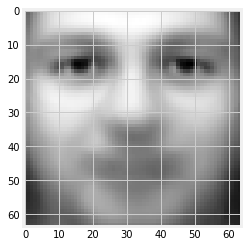

In [7]:
def mean_face(faces):
    """Compute the mean of the `faces`
    
    Arguments
    ---------
    faces: (N, 64 * 64) ndarray representing the faces dataset.
    
    Returns
    -------
    mean_face: (64, 64) ndarray which is the mean of the faces.
    """
    mean_face = mean(faces)
    return mean_face

plt.imshow(mean_face(faces).reshape((64, 64)), cmap='gray');

To put things into perspective, we can benchmark the two different implementation with the `%time` function
in the following way:

In [8]:
# We have some huge data matrix, and we want to compute its mean
X = np.random.randn(100000, 20)
# Benchmarking time for computing mean
%time mean_naive(X)
%time mean(X)
pass

Wall time: 190 ms
Wall time: 4.49 ms


In [9]:
# Benchmarking time for computing covariance
%time cov_naive(X)
%time cov(X)
pass

Wall time: 1.79 s
Wall time: 29.9 ms


Alternatively, we can also see how running time increases as we increase the size of our dataset.
In the following cell, we run `mean`, `mean_naive` and `cov`, `cov_naive` for many times on different sizes of
the dataset and collect their running time. If you are less familiar with Python, you may want to spend
some time understanding what the code does. __Understanding how your code scales with the size of your dataset (or dimensionality of the dataset) is crucial__ when you want to apply your algorithm to larger dataset. This is really important when we propose alternative methods a more efficient algorithms to solve the same problem. We will use these techniques again later in this course to analyze the running time of our code.

In [10]:
def time(f, repeat=100):
    """A helper function to time the execution of a function.
    
    Arguments
    ---------
    f: a function which we want to time it.
    repeat: the number of times we want to execute `f`
    
    Returns
    -------
    the mean and standard deviation of the execution.
    """
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [11]:
fast_time = []
slow_time = []

for size in np.arange(100, 5000, step=100):
    X = np.random.randn(size, 20)
    f = lambda : mean(X)
    mu, sigma = time(f)
    fast_time.append((size, mu, sigma))
    
    f = lambda : mean_naive(X)
    mu, sigma = time(f)
    slow_time.append((size, mu, sigma))

fast_time = np.array(fast_time)
slow_time = np.array(slow_time)

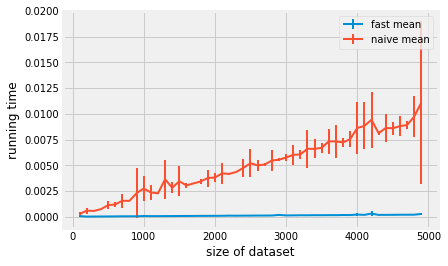

In [12]:
fig, ax = plt.subplots()
ax.errorbar(fast_time[:,0], fast_time[:,1], fast_time[:,2], label='fast mean', linewidth=2)
ax.errorbar(slow_time[:,0], slow_time[:,1], slow_time[:,2], label='naive mean', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

In [13]:
fast_time_cov = []
slow_time_cov = []
for size in np.arange(100, 5000, step=100):
    X = np.random.randn(size, 20)
    f = lambda : cov(X)
    mu, sigma = time(f)
    fast_time_cov.append((size, mu, sigma))
    
    f = lambda : cov_naive(X)
    mu, sigma = time(f)
    slow_time_cov.append((size, mu, sigma))

fast_time_cov = np.array(fast_time_cov)
slow_time_cov = np.array(slow_time_cov)

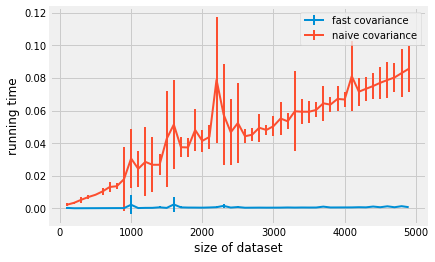

In [14]:
fig, ax = plt.subplots()
ax.errorbar(fast_time_cov[:,0], fast_time_cov[:,1], fast_time_cov[:,2], label='fast covariance', linewidth=2)
ax.errorbar(slow_time_cov[:,0], slow_time_cov[:,1], slow_time_cov[:,2], label='naive covariance', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

## 2. Affine Transformation of Dataset
We are also going to verify a few properties about the mean and
covariance of affine transformation of random variables.

Consider a data matrix $\boldsymbol{X}$ of size (N, D). We would like to know
what is the covariance when we apply an affine transformation $\boldsymbol{A}\boldsymbol{x}_i + \boldsymbol{b}$ with a matrix $\boldsymbol A$ and a vector $\boldsymbol b$ to each datapoint $\boldsymbol{x}_i$ in $\boldsymbol{X}$, i.e.
we would like to know what happens to the mean and covariance for the new dataset if we apply affine transformation.

In [15]:
def affine_mean(mean, A, b):
    """Compute the mean after affine transformation
    Args:
        mean: ndarray, the mean vector
        A, b: affine transformation applied to x
    Returns:
        mean vector after affine transformation
    """
    affine_m = A @ mean + b
    return affine_m

# ===YOU SHOULD EDIT THIS FUNCTION===
def affine_covariance(S, A, b):
    """Compute the covariance matrix after affine transformation
    Args:
        S: ndarray, the covariance matrix
        A, b: affine transformation applied to each element in X        
    Returns:
        covariance matrix after the transformation
    """
    affine_cov = A @ S @ A.T
    return affine_cov

Once the two functions above are implemented, we can verify the correctness our implementation. Assuming that we have some matrix $\boldsymbol A$ and vector $\boldsymbol b$.

In [16]:
random = np.random.RandomState(42)
A = random.randn(4,4)
b = random.randn(4)

Next we can generate some random dataset $\boldsymbol{X}$

In [18]:
X = random.randn(100, 4)

Assuming that for some dataset $\boldsymbol X$, the mean and covariance are $\boldsymbol m$, $\boldsymbol S$, and for the new dataset after affine transformation $ \boldsymbol X'$, the mean and covariance are $\boldsymbol m'$ and $\boldsymbol S'$, then we would have the following identity:

$$\boldsymbol m' = \text{affine_mean}(\boldsymbol m, \boldsymbol A, \boldsymbol b)$$

$$\boldsymbol S' = \text{affine_covariance}(\boldsymbol S, \boldsymbol A, \boldsymbol b)$$

In [19]:
X1 = ((A @ (X.T)).T + b)  # applying affine transformation once
X2 = ((A @ (X1.T)).T + b) # and again

One very useful way to compare whether arrays are equal/similar is use the helper functions
in `numpy.testing`. the functions in `numpy.testing` will throw an `AssertionError` when the output does not satisfy the assertion.

In [20]:
np.testing.assert_almost_equal(mean(X1), affine_mean(mean(X), A, b))
np.testing.assert_almost_equal(cov(X1),  affine_covariance(cov(X), A, b))
print('correct')

correct


In [21]:
np.testing.assert_almost_equal(mean(X2), affine_mean(mean(X1), A, b))
np.testing.assert_almost_equal(cov(X2),  affine_covariance(cov(X1), A, b))
print('correct')

correct
